## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms
from torchvision.utils import make_grid

from torchmetrics import ConfusionMatrix

import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import matplotlib.pyplot as plt
%matplotlib inline

## Explore the Data

Import dataframes seperatley, then merge and shuffle them

In [2]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively
_train = pd.read_csv('./train.csv')
_test = pd.read_csv('./test_labeled.csv', sep=';')

In [3]:
def extract_DF(df, label):
    temp = df.loc[df['label'] < label+1]
    return temp.loc[temp['label'] > label-1]

In [4]:
# test datasets
a1 = extract_DF(_train, 0)
a2 = extract_DF(_train, 1)

train_df = pd.concat([a1, a2])
train_df = train_df.sample(frac=1).reset_index(drop=True)

# train datasets
e1 = extract_DF(_test, 0)
e2 = extract_DF(_test, 1)

test_df = pd.concat([e1, e2])
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [5]:
print(train_df.head(10))
print(test_df.head(10))

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      0       0       0       0       0       0       0       0       0   
3      0       0       0       0       0       0       0       0       0   
4      1       0       0       0       0       0       0       0       0   
5      1       0       0       0       0       0       0       0       0   
6      0       0       0       0       0       0       0       0       0   
7      1       0       0       0       0       0       0       0       0   
8      0       0       0       0       0       0       0       0       0   
9      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1      

In [6]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_train = len(train_df)
n_pixels = len(train_df.columns) - 1
n_class = len(set(train_df['label']))

print("Number of training samples:",n_train) #{0}'.format(n_train))
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 8816
Number of training pixels:  784
Number of classes:  2


In [7]:
# 28x28 pixels image, has first 2 columns as ImageId and label respectively

n_test = len(test_df)
n_pixels = len(test_df.columns) - 1
n_class = len(set(test_df['label']))

print("Number of training samples:",n_test) #{0}'.format(n_train))
print('Number of training pixels: ', n_pixels)
print('Number of classes: ', n_class)

Number of training samples: 5939
Number of training pixels:  784
Number of classes:  2


## Display Some Images

In [9]:
def dispImage(df, row):
    grid = make_grid(torch.Tensor((df.iloc[row, 1:].to_numpy()/255.).reshape((-1, 28, 28))).unsqueeze(1), nrow=7)
    plt.rcParams['figure.figsize'] = (32, 150)
    plt.imshow(grid.numpy().transpose((1,2,0)))
    plt.axis('off')

0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1


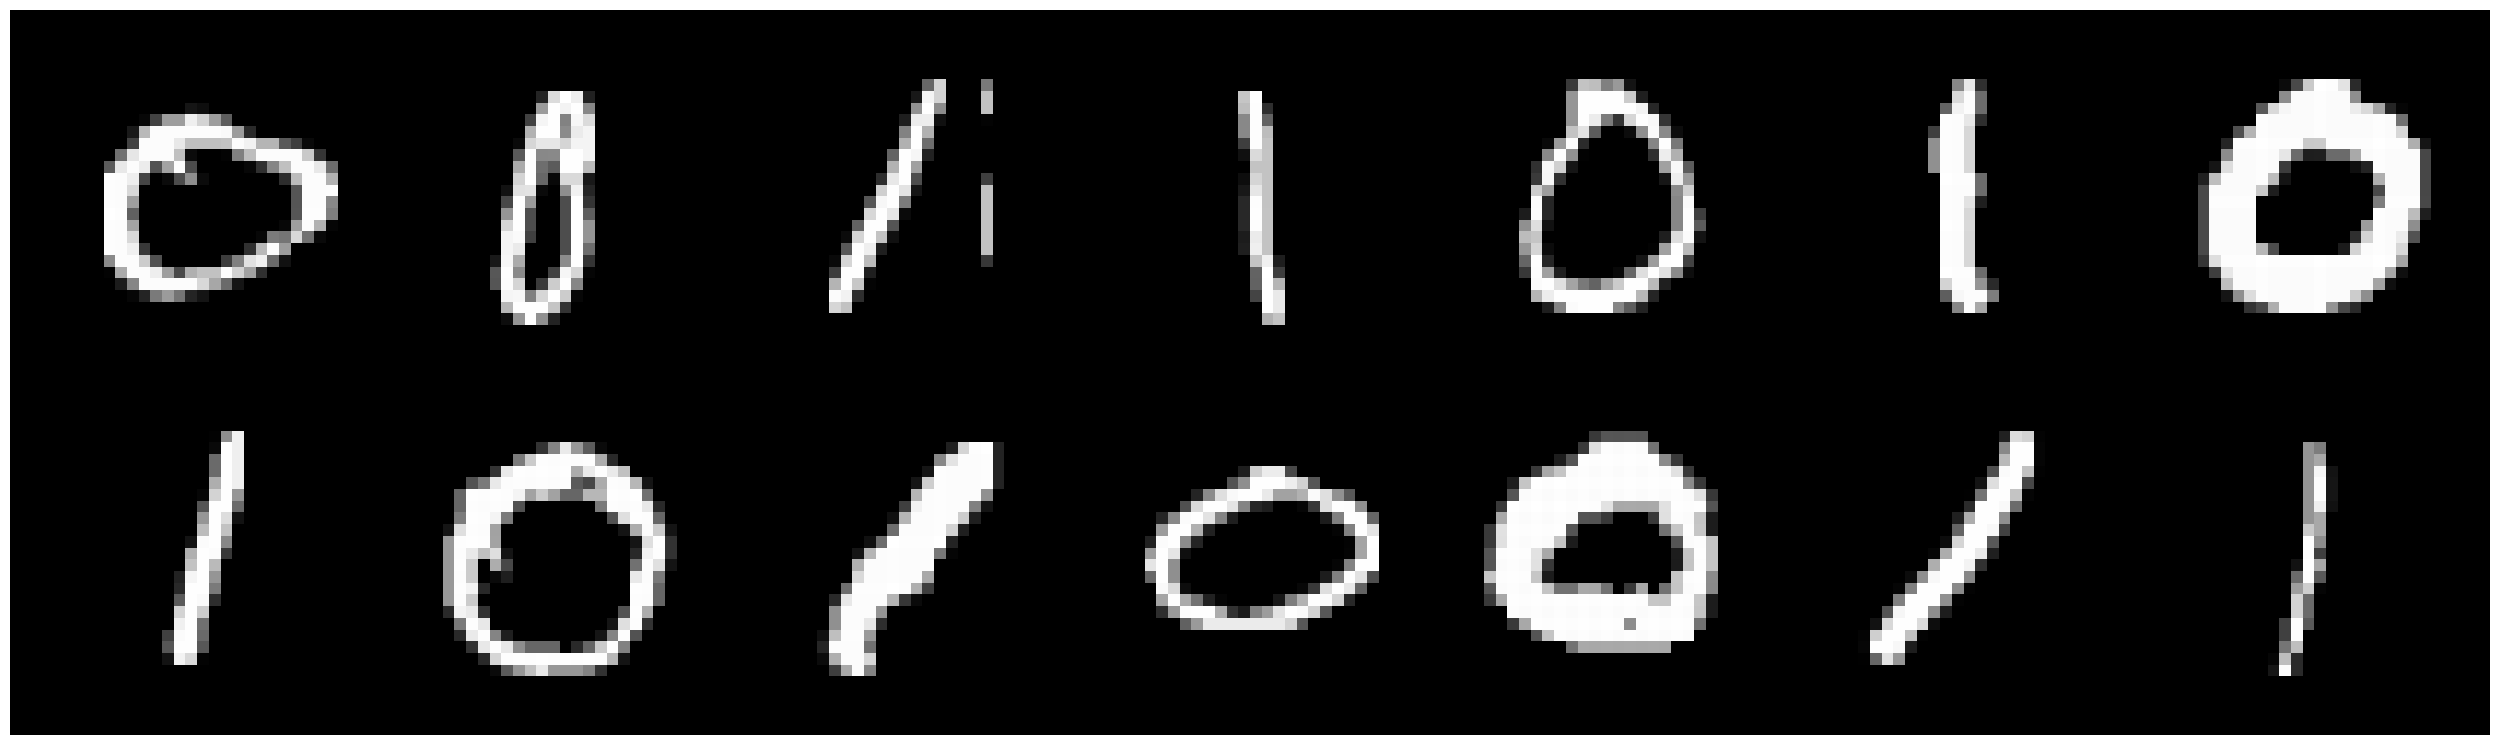

In [12]:
random_sel = np.random.randint(n_train, size=14)
ten = range(10)

dispImage(train_df, random_sel)
print(*list(train_df.iloc[random_sel, 0].values), sep = ', ')

Shape of the train_df is:  (8816, 785)
Shape of the test_df is:  (5939, 785)


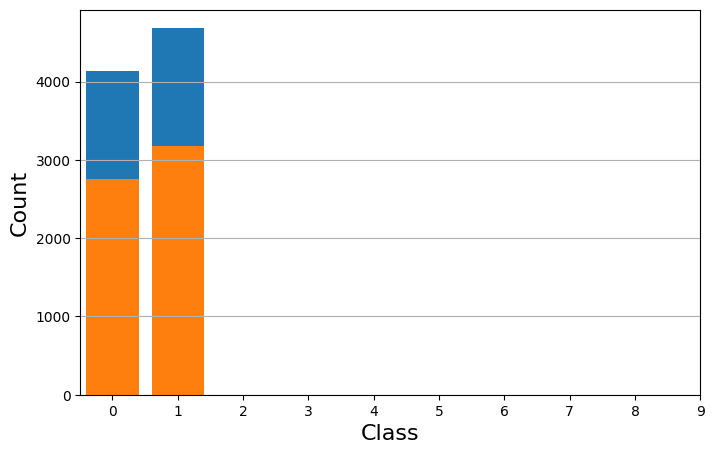

In [14]:
def showHistogram(df):
    plt.rcParams['figure.figsize'] = (8, 5)
    plt.bar(df['label'].value_counts().index, df['label'].value_counts())
    plt.xticks(np.arange(10))
    plt.xlabel('Class', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.grid('on', axis='y')

showHistogram(train_df) # Blue si train
showHistogram(test_df) # Orange is test
print("Shape of the train_df is: ", train_df.shape)
print("Shape of the test_df is: ", test_df.shape)

## Data Loader Class

In [15]:
class MNIST_data(Dataset):
    """MNIST dtaa set"""
    
    def __init__(self, 
                 df_, 
                 isTest = bool,
                 transform = transforms.Compose([transforms.ToPILImage(), 
                                                 transforms.ToTensor(), 
                                                 transforms.Normalize(mean=(0.5,), std=(0.5,))
                                                ])
                ):
        
        df = df_ #pd.read_csv(file_path)
        
        if isTest:
            # test data
            # X is pixel values
            # Y is labels
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = None
        else:
            # training data
            self.X = df.iloc[:,1:].values.reshape((-1,28,28)).astype(np.uint8)[:,:,:,None]
            self.y = torch.from_numpy(df.iloc[:,0].values)
         
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

    def getY(self, idx):
        if self.y is not None:
            return self.y[idx]
        else:
            print("There is no Y component")

## Random Rotation Transformation
Randomly rotate the image. Available in upcoming torchvision but not now.

In [16]:
class RandomRotation(object):
    """
    https://github.com/pytorch/vision/tree/master/torchvision/transforms
    Rotate the image by angle.
    Args:
        degrees (sequence or float or int): Range of degrees to select from.
            If degrees is a number instead of sequence like (min, max), the range of degrees
            will be (-degrees, +degrees).
        resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
        expand (bool, optional): Optional expansion flag.
            If true, expands the output to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
        center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
    """

    def __init__(self, degrees, resample=False, expand=False, center=None):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError("If degrees is a single number, it must be positive.")
            self.degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError("If degrees is a sequence, it must be of len 2.")
            self.degrees = degrees

        self.resample = resample
        self.expand = expand
        self.center = center

    @staticmethod
    def get_params(degrees):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        angle = np.random.uniform(degrees[0], degrees[1])

        return angle

    def __call__(self, img):
        """
            img (PIL Image): Image to be rotated.
        Returns:
            PIL Image: Rotated image.
        """
        
        def rotate(img, angle, resample=False, expand=False, center=None):
            """Rotate the image by angle and then (optionally) translate it by (n_columns, n_rows)
            Args:
            img (PIL Image): PIL Image to be rotated.
            angle ({float, int}): In degrees degrees counter clockwise order.
            resample ({PIL.Image.NEAREST, PIL.Image.BILINEAR, PIL.Image.BICUBIC}, optional):
            An optional resampling filter.
            See http://pillow.readthedocs.io/en/3.4.x/handbook/concepts.html#filters
            If omitted, or if the image has mode "1" or "P", it is set to PIL.Image.NEAREST.
            expand (bool, optional): Optional expansion flag.
            If true, expands the output image to make it large enough to hold the entire rotated image.
            If false or omitted, make the output image the same size as the input image.
            Note that the expand flag assumes rotation around the center and no translation.
            center (2-tuple, optional): Optional center of rotation.
            Origin is the upper left corner.
            Default is the center of the image.
            """
                
            return img.rotate(angle, resample, expand, center)

        angle = self.get_params(self.degrees)

        return rotate(img, angle, self.resample, self.expand, self.center)

## Random Vertical and Horizontal Shift

In [17]:
class RandomShift(object):
    def __init__(self, shift):
        self.shift = shift
        
    @staticmethod
    def get_params(shift):
        """Get parameters for ``rotate`` for a random rotation.
        Returns:
            sequence: params to be passed to ``rotate`` for random rotation.
        """
        hshift, vshift = np.random.uniform(-shift, shift, size=2)

        return hshift, vshift 
    def __call__(self, img):
        hshift, vshift = self.get_params(self.shift)
        
        return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
    

## Load the Data into Tensors
For the training set, apply random rotation within the range of (-45, 45) degrees, shift by (-3, 3) pixels and normalize pixel values to [-1, 1]. For the test set, only apply nomalization.

In [24]:
batch_size = 64

train_dataset = MNIST_data(train_df, isTest=False, transform = transforms.Compose(
                            [transforms.ToPILImage(), RandomRotation(degrees=20), RandomShift(3),
                             transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))]))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)


test_dataset = MNIST_data(test_df, isTest=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

test_y_dataset = MNIST_data(test_df, isTest=False)
test_y_loader = torch.utils.data.DataLoader(dataset=test_y_dataset, batch_size=batch_size, shuffle=True)

train_x_dataset = MNIST_data(train_df, isTest=True)
train_x_loader = torch.utils.data.DataLoader(dataset=train_x_dataset, batch_size=batch_size, shuffle=True)

## Demonstration of Transformations 

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1358/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1358/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)


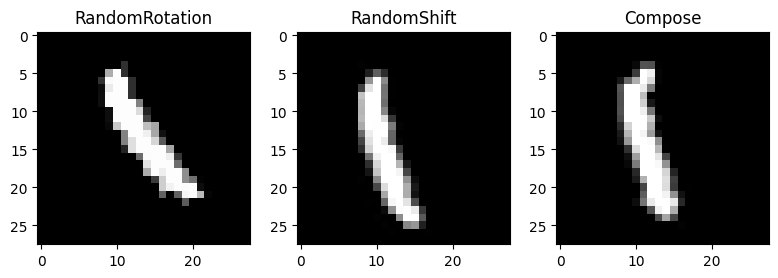

In [25]:
rotate = RandomRotation(60)
shift = RandomShift(5)
composed = transforms.Compose([RandomRotation(20),
                               RandomShift(3)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = transforms.ToPILImage()(train_df.iloc[65,1:].values.reshape((28,28)).astype(np.uint8)[:,:,None])
for i, tsfrm in enumerate([rotate, shift, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    ax.imshow(np.reshape(np.array(list(transformed_sample.getdata())), (-1,28)), cmap='gray')    

plt.show()

## Network Structure

In [26]:
class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(64 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p = 0.5),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
          
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        
        return x     

## Initialize the Network Model
Initialize the network as 'model'

In [27]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1358/4196366409.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


## Training and Evaluation

In [28]:
loss_values = []
def train(epoch):
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss_val = F.cross_entropy(output, target, size_average=False).data
        loss_values.append(loss_val)
        
        loss.backward()
        optimizer.step()
        exp_lr_scheduler.step()
        
        if (batch_idx + 1)% 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
    
    print(loss_values[0:5], loss_values[len(loss_values)-1] )
    plt.plot(loss_values)
    plt.ylabel('Loss')
    plt.show()

In [29]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1358/2105636642.py:17: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/var/folders/h2/0yz4qqt96pl7pfv1jmlkqfp40000gn/T/ipykernel_1358/2105636642.py:17: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  return img.transform(img.size, Image.AFFINE, (1,0,hshift,0,1,vshift), resample=Image.BICUBIC, fill=1)
/Users/ilerisoy/opt/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 0 [640/8816 (7%)]	Loss: 0.024122
Train Epoch: 0 [1280/8816 (14%)]	Loss: 0.018395
Train Epoch: 0 [1920/8816 (22%)]	Loss: 0.012072
Train Epoch: 0 [2560/8816 (29%)]	Loss: 0.021871
Train Epoch: 0 [3200/8816 (36%)]	Loss: 0.021083
Train Epoch: 0 [3840/8816 (43%)]	Loss: 0.015654
Train Epoch: 0 [4480/8816 (51%)]	Loss: 0.036786
Train Epoch: 0 [5120/8816 (58%)]	Loss: 0.002598
Train Epoch: 0 [5760/8816 (65%)]	Loss: 0.117710
Train Epoch: 0 [6400/8816 (72%)]	Loss: 0.023340
Train Epoch: 0 [7040/8816 (80%)]	Loss: 0.006781
Train Epoch: 0 [7680/8816 (87%)]	Loss: 0.001453
Train Epoch: 0 [8320/8816 (94%)]	Loss: 0.014645
[tensor(189.5137), tensor(58.3451), tensor(17.4439), tensor(9.6116), tensor(2.1892)] tensor(4.0206)


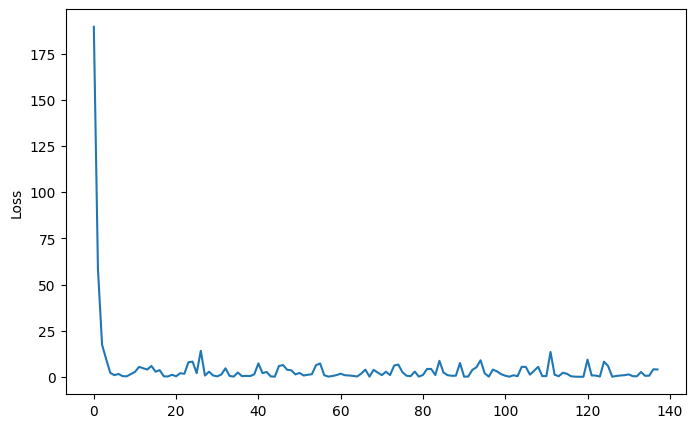


Average loss: 0.0326, Accuracy: 8730/8816 (99.024%)



In [30]:
n_epochs = 1

for epoch in range(n_epochs):
    train(epoch)
    evaluate(train_loader)

## Prediction

In [31]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        #print(output)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        #print(pred)
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

## Performance of Train Dataset

In [52]:
train_pred = prediciton(train_x_loader)
#train_pred = prediciton(train_x_loader)
#train_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(train_dataset)+1)[:,None], train_pred.numpy()], 
                      #columns=['ImageId', 'label'])

In [56]:
train_prediction_df = pd.DataFrame(np.c_[train_pred.numpy()], columns=['label'])

# Make a numpay array by predcited labels
train_predictions = train_prediction_df.iloc[:, 0].to_numpy()
train_labels = train_df.iloc[:,0].to_numpy()
print(len(train_predictions), train_predictions[:10], train_labels[:10])

8816 [0 1 1 1 1 1 1 1 0 0] [1 0 0 0 1 1 0 1 0 1]


In [57]:
count = 0
train_index = []

for i in range(len(train_predictions)):
    if train_labels[i] == train_predictions[i]:
        
        continue
    else:
        train_index.append(i)
        count += 1
        print("Label is: ", train_labels[i], "Predcition is: ", 
              train_predictions[i], "index is: ", i)
print(count)

Label is:  1 Predcition is:  0 index is:  0
Label is:  0 Predcition is:  1 index is:  1
Label is:  0 Predcition is:  1 index is:  2
Label is:  0 Predcition is:  1 index is:  3
Label is:  0 Predcition is:  1 index is:  6
Label is:  1 Predcition is:  0 index is:  9
Label is:  1 Predcition is:  0 index is:  10
Label is:  0 Predcition is:  1 index is:  11
Label is:  1 Predcition is:  0 index is:  15
Label is:  0 Predcition is:  1 index is:  16
Label is:  1 Predcition is:  0 index is:  17
Label is:  1 Predcition is:  0 index is:  18
Label is:  0 Predcition is:  1 index is:  20
Label is:  1 Predcition is:  0 index is:  22
Label is:  0 Predcition is:  1 index is:  23
Label is:  0 Predcition is:  1 index is:  24
Label is:  0 Predcition is:  1 index is:  29
Label is:  0 Predcition is:  1 index is:  31
Label is:  1 Predcition is:  0 index is:  34
Label is:  1 Predcition is:  0 index is:  36
Label is:  1 Predcition is:  0 index is:  38
Label is:  1 Predcition is:  0 index is:  40
Label is:  1 Pre

In [72]:
random_sel = np.random.randint(count, size=14)
print(random_sel)
print(random_sel[:10])

[2547 1731  690 3841 1272 3754 4385 3709  212 4187  959   21 1843 2928]
[2547 1731  690 3841 1272 3754 4385 3709  212 4187]


  Label -- Pred -- Index
1     1    0       0
2     0    1       1
3     0    1       2
4     0    1       3
5     0    1       6
6     1    0       9
7     1    0       10
8     0    1       11
9     1    0       15
10     0    1       16
11     1    0       17
12     1    0       18
13     0    1       20
14     1    0       22


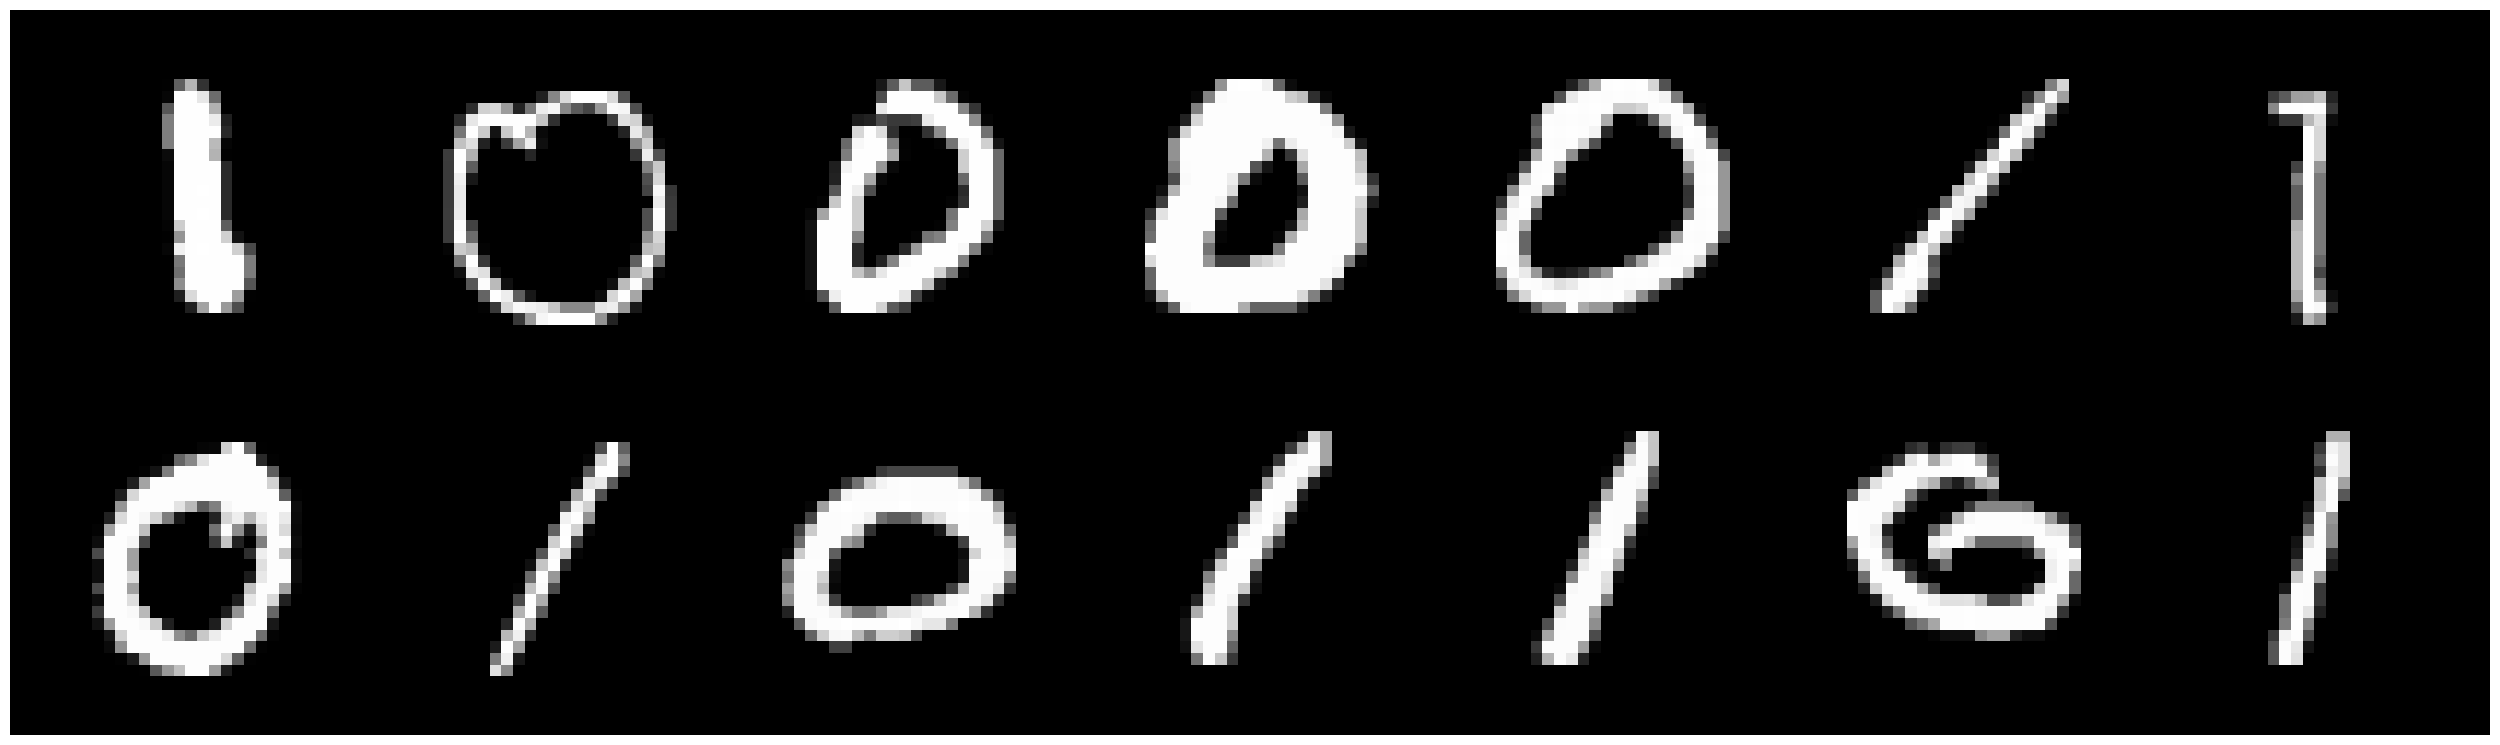

In [79]:
random_sel = np.random.randint(count, size=14)
num = np.arange(14)

print("  Label -- Pred -- Index")

count2 = 0
for i in range(14):
    count2 += 1
    print(count2, "   ",train_df.iloc[train_index[i],0], "  ", 
          train_predictions[train_index[i]], "     ", train_index[i], 
         )

dispImage(train_df, train_index[:14])

In [80]:
con_train = confusion_matrix(train_dataset.y, train_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_train,"\n")


Confusion Matrix is:

[[1926 2206]
 [2180 2504]] 



In [43]:
# Class 0 is treated as Negative
tn, fp, fn, tp = con_train.ravel()

prec_test = tp/(tp+fp)
rec_test = tp/(tp+fn)

sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)
print("Recall is: ", rec_test)

print("\nSensivity is: ", sens)
print("Specificity is: ", spec)

print("TP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)

Accuracy is: % 49.86388384754991

Precision is:  0.5280254777070064
Recall is:  0.5309564474807856

Sensivity is:  0.5309564474807856
Specificity is:  0.46200387221684414
TP:  2487 FP:  2223
FN:  2197   TN:  1909


## Performance of Test Dataset

In [81]:
test_pred = prediciton(test_loader)
test_prediction_df = pd.DataFrame(np.c_[np.arange(1, len(test_dataset)+1)[:,None], test_pred.numpy()], 
                      columns=['ImageId', 'Label'])

In [82]:
test_predictions = test_prediction_df.iloc[:, 1].to_numpy()
test_labels = test_df.iloc[:,1].to_numpy()
print(len(test_predictions))

5939


In [86]:
count3 = 0
test_index = np.array(range(10250))

for i in range(len(test_predictions)):
    if test_y_dataset.getY(i).item() == test_predictions[i]:
        continue
    else:
        test_index[count3] = i
        count3 += 1
        print("Label is: ", test_y_dataset.getY(i).item(), "Predcition is: ", 
              test_predictions[i], "index is: ", i)
print(count3)

Label is:  0 Predcition is:  1 index is:  2
Label is:  1 Predcition is:  0 index is:  3
Label is:  0 Predcition is:  1 index is:  4
Label is:  0 Predcition is:  1 index is:  5
Label is:  0 Predcition is:  1 index is:  6
Label is:  0 Predcition is:  1 index is:  9
Label is:  0 Predcition is:  1 index is:  10
Label is:  1 Predcition is:  0 index is:  11
Label is:  1 Predcition is:  0 index is:  12
Label is:  0 Predcition is:  1 index is:  14
Label is:  1 Predcition is:  0 index is:  16
Label is:  0 Predcition is:  1 index is:  17
Label is:  0 Predcition is:  1 index is:  18
Label is:  1 Predcition is:  0 index is:  20
Label is:  1 Predcition is:  0 index is:  22
Label is:  1 Predcition is:  0 index is:  25
Label is:  0 Predcition is:  1 index is:  26
Label is:  1 Predcition is:  0 index is:  31
Label is:  0 Predcition is:  1 index is:  32
Label is:  1 Predcition is:  0 index is:  35
Label is:  0 Predcition is:  1 index is:  37
Label is:  1 Predcition is:  0 index is:  41
Label is:  1 Pre

In [84]:
con_test = confusion_matrix(test_y_dataset.y, test_predictions)
# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with 
# true label being i-th class and predicted label being j-th class.
print("\nConfusion Matrix is:\n")
print(con_test,"\n")


Confusion Matrix is:

[[1253 1505]
 [1482 1699]] 



In [85]:
# Class 0 is treated as Negative
tn, fp, fn, tp = con_test.ravel()

prec_test = tp/(tp+fp)
rec_test = tp/(tp+fn)

sens = tp/(tp+fn)
spec = tn/(tn+fp)

total = tp+tn+fn+fp
acc = (tp+tn)*100/total
print("Accuracy is: %", acc)

print("\nPrecision is: ", prec_test)
print("Recall is: ", rec_test)

print("\nSensivity is: ", sens)
print("Specificity is: ", spec)


print("TP: ", tp, "FP: ", fp)
print("FN: ", fn, "  TN: ", tn)

Accuracy is: % 49.70533759892238

Precision is:  0.5302746566791511
Recall is:  0.534108770826784

Sensivity is:  0.534108770826784
Specificity is:  0.4543147208121827
TP:  1699 FP:  1505
FN:  1482   TN:  1253
